In [1]:
# General imports
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize Dataset
df = pd.read_csv("../Sentiment_IMDB_Dataset.csv")

# Initialize stopwords 
stopwords = stopwords.words('english')
stopwords.remove('not')

# Initialize stemmer and lemmatizer for text preprocessing
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [3]:
# Helper function to read the data over loops (solve out of memory problem)
def read_data(dataframe, start, end):
  df = dataframe[start : end]
  return df

# Helper function to clean text and split by words
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text) # Remove non-letters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra white spaces

    # Split words 
    words = re.split(r'\W+', text)
    # Stem, Lemmatize, and remove stopwords 
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word not in stopwords] 
    
    # return list of strings
    words = " ".join(words)
    
    return words

# Print Size of an np array
def print_size(data):
  size_in_bytes = data.nbytes
  size_in_megabytes = size_in_bytes / (1024**2)
  size_in_gigabytes = size_in_bytes / (1024**3)

  print(f"- Size of Corpus: {size_in_megabytes:.2f} MB - {size_in_gigabytes:.2f} GB")

In [4]:
# Clean Data
reviews = df['review'].apply( lambda review: clean_text(review) )

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize n_gram_vectorizer
n_gram_vectorizer = CountVectorizer(ngram_range=(1,2))

# Transform data into n_grams
transformed_reviews = n_gram_vectorizer.fit_transform(reviews)

print(f"Number of grams in vocabulary: {len(n_gram_vectorizer.vocabulary_)}")

Number of grams in vocabulary: 2641907


In [6]:
## Visualize the frequency of ngrams in our data (Most frequent vs least frequent)
# Sum the term frequencies across all reviews
word_counts = transformed_reviews.sum(axis=0).A1

# Get the vocabulary
vocab = n_gram_vectorizer.get_feature_names_out()

# Create a DataFrame with words and their corresponding frequencies
word_freq = pd.DataFrame({'word': vocab, 'frequency': word_counts})

# Sort the DataFrame by frequency in descending order
word_freq = word_freq.sort_values(by='frequency', ascending=False)

word_freq

,word,frequency
1524423,movi,103240
847835,film,95853
1596774,not,60763
1637720,one,55435
1332187,like,45197
...,...,...
1302645,leader endeavour,1
1302644,leader end,1
1302643,leader emotionless,1
1302642,leader el,1


In [7]:
# After cleaning and seeing the word_counts, replace the df's review column by our adjusted and cleaned reviews
df['review'] = reviews

# Label encode class label
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize Logistic Regression model
LR = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1)

# Initialize thresholds to load data as batches of 250 reviews.
thresholds = range(250, 50000, 250)
iterator = 0

# Store classification metrics
accuracy_history = []
precision_history = []
recall_history = []
f1_history = []
roc_aucs_history = []

In [9]:
## Train model on batches of 250

for threshold in thresholds:
  # Load data
  start = threshold - 250
  data = read_data(dataframe=df, start=start, end=threshold)

  # Separate Data
  reviews = data['review']
  labels = data['sentiment']

  # Transform reviews to bag of 1_2_grams
  reviews = n_gram_vectorizer.transform(reviews).toarray()

  # Print size of the corpus
  print_size(data=reviews)

  # Split the batch of data
  X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, stratify=labels, shuffle=True)

  # Reshape labels
  y_train = np.reshape(y_train, (len(y_train),))
  y_test = np.reshape(y_test, (len(y_test),))

  # Train model on current batch
  LR.partial_fit(X_train, y_train, classes=np.array([0, 1]))
  
  # Predict
  y_pred = LR.predict(X_test)

  # Evaluate Predictions
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  iterator += 1
  print(f"LR: {iterator} - Threshold: {threshold} - Accuracy: {accuracy:.3f} - Precision: {precision:.3f} - Recall: {recall:.3f} - F1 Score: {f1:.3f} - ROC-AUC Score: {roc_auc:.3f}")

  # Store metrics for plotting
  accuracy_history.append(accuracy) 
  precision_history.append(precision)
  recall_history.append(recall)
  f1_history.append(f1)
  roc_aucs_history.append(roc_auc)

- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 1 - Threshold: 250 - Accuracy: 0.620 - Precision: 0.750 - Recall: 0.261 - F1 Score: 0.387 - ROC-AUC Score: 0.593
- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 2 - Threshold: 500 - Accuracy: 0.700 - Precision: 0.857 - Recall: 0.480 - F1 Score: 0.615 - ROC-AUC Score: 0.700
- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 3 - Threshold: 750 - Accuracy: 0.800 - Precision: 0.808 - Recall: 0.808 - F1 Score: 0.808 - ROC-AUC Score: 0.800
- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 4 - Threshold: 1000 - Accuracy: 0.740 - Precision: 0.733 - Recall: 0.815 - F1 Score: 0.772 - ROC-AUC Score: 0.733
- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 5 - Threshold: 1250 - Accuracy: 0.740 - Precision: 0.760 - Recall: 0.731 - F1 Score: 0.745 - ROC-AUC Score: 0.740
- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 6 - Threshold: 1500 - Accuracy: 0.660 - Precision: 0.625 - Recall: 0.926 - F1 Score: 0.746 - ROC-AUC Score: 0.637
- Size of Corpus: 5039.04 MB - 4.92 GB
LR: 7 - Threshold: 175

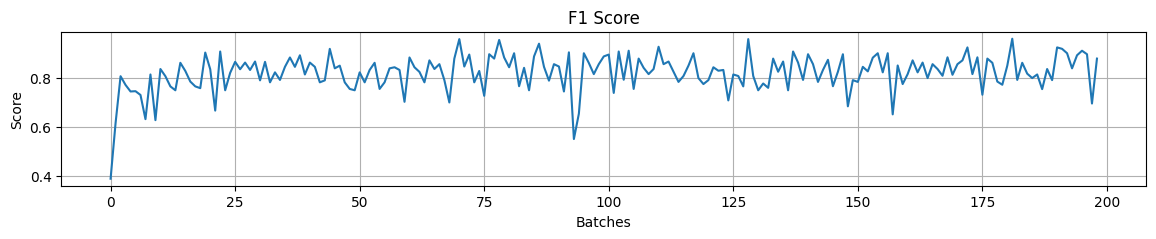

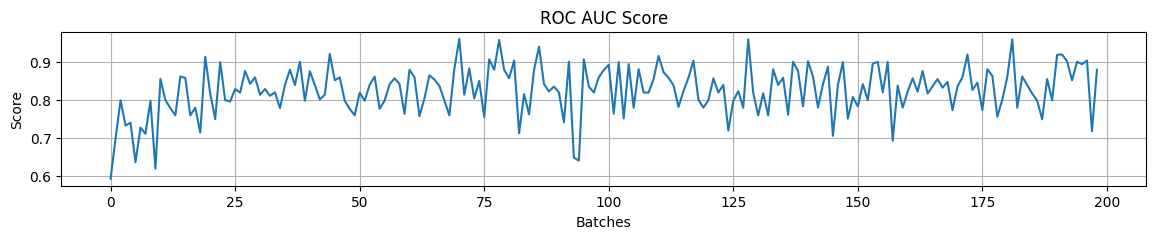

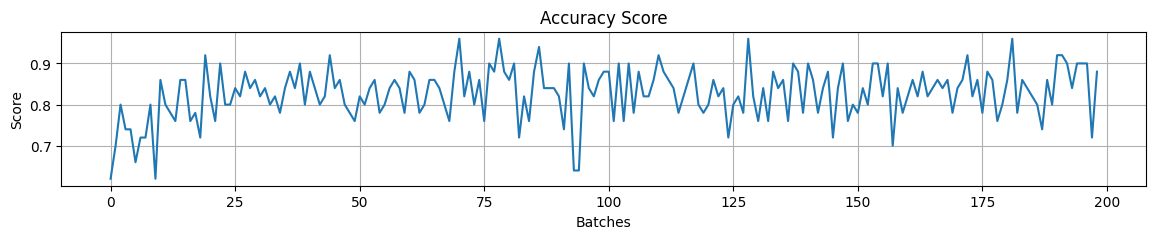

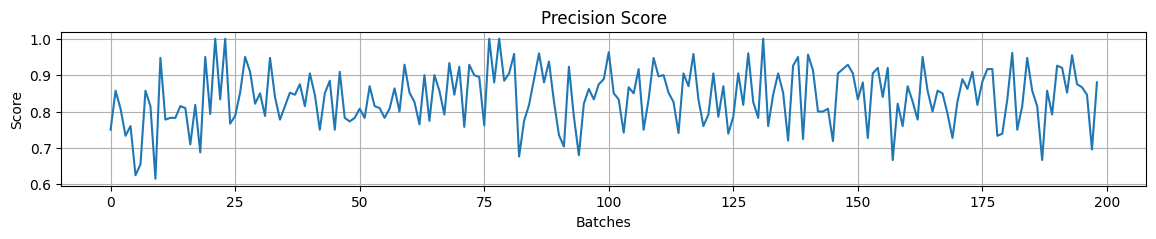

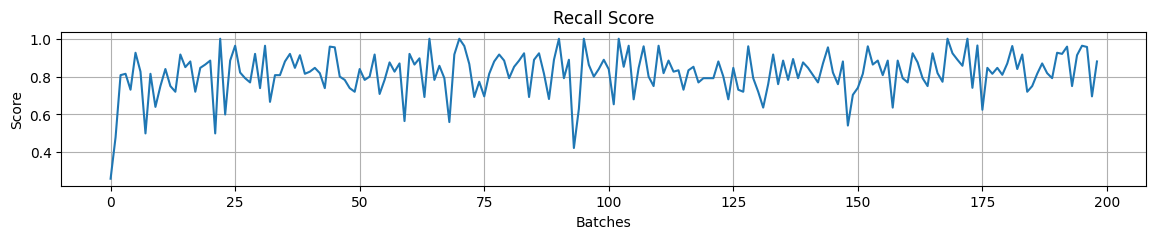

In [10]:
def plot_figure(metric, title):
  plt.figure(figsize=(14, 2))
  plt.plot(metric)
  plt.title(title)
  plt.xlabel("Batches")
  plt.ylabel("Score")
  plt.grid(True)

plot_figure(metric=f1_history, title="F1 Score")
plot_figure(metric=roc_aucs_history, title="ROC AUC Score")
plot_figure(metric=accuracy_history, title="Accuracy Score")
plot_figure(metric=precision_history, title="Precision Score")
plot_figure(metric=recall_history, title="Recall Score")

In [12]:
# Test model on a manually given sample text

phrases = ["The movie had an excellent storyline with amazing acting, but the ending was quite disappointing and left me unsatisfied.", ## Negative

          "This movie was absolutely fantastic! The story was gripping, the acting was top-notch, and the cinematography was stunning. I was on the edge of my seat the entire time and couldn't look away. It's been a long time since a film has captivated me like this. Highly recommend!", ## Positive 

          "The film had its moments, but overall, it failed to leave a lasting impression. The characters lacked depth, and the storyline felt disjointed. It's a forgettable movie that I wouldn't recommend to others.", # neutral - to - negative
          
          "I hate this movie", # Negative

          "I have a love hate relationship with this movie", # Negative

          "I wish I could watch it again now" # Positive
          ] 

answers = [0, 1, 0, 0, 0, 1]

for i in range(len(phrases)):
  phrase = phrases[i]
  phrase = [clean_text(phrase)]
  phrase = n_gram_vectorizer.transform(phrase).toarray()

  # Test Logistic Regression model
  prediction = LR.predict(phrase) # Predict
  prediction = prediction[0] # Adjust prediction format to print it

  if prediction == 1.0: print(f"{i}: LR Prediction: {prediction} => Positive Sentiment => {prediction == answers[i]}")
  else: print(f"{i}: LR Prediction: {prediction} => Negative Sentiment => {prediction == answers[i]}")

0: LR Prediction: 0 => Negative Sentiment => True
1: LR Prediction: 1 => Positive Sentiment => True
2: LR Prediction: 0 => Negative Sentiment => True
3: LR Prediction: 1 => Positive Sentiment => False
4: LR Prediction: 1 => Positive Sentiment => False
5: LR Prediction: 0 => Negative Sentiment => False


In [33]:
print(f"Mean accuracy:\nLast 100 Batches: {np.mean(accuracy_history[100:]):.2f} - Last 40 Batches: {np.mean(accuracy_history[160:]):.2f} - Last 20 Batches {np.mean(accuracy_history[180:]):.2f}\n")

print(f"Mean precision:\nLast 100 Batches: {np.mean(precision_history[100:]):.2f} - Last 40 Batches: {np.mean(precision_history[160:]):.2f} - Last 20 Batches {np.mean(precision_history[180:]):.2f}\n")

print(f"Mean recall:\nLast 100 Batches: {np.mean(recall_history[100:]):.2f} - Last 40 Batches: {np.mean(recall_history[160:]):.2f} - Last 20 Batches {np.mean(recall_history[180:]):.2f}\n")

print(f"Mean f1:\nLast 100 Batches: {np.mean(f1_history[100:]):.2f} - Last 40 Batches: {np.mean(f1_history[160:]):.2f} - Last 20 Batches {np.mean(f1_history[180:]):.2f}\n")

print(f"Mean roc_auc:\nLast 100 Batches: {np.mean(roc_aucs_history[100:]):.2f} - Last 40 Batches: {np.mean(roc_aucs_history[160:]):.2f} - Last 20 Batches {np.mean(roc_aucs_history[180:]):.2f}\n")

print("Each batch is 250 reviews")

Mean accuracy:
Last 100 Batches: 0.84 - Last 40 Batches: 0.85 - Last 20 Batches 0.85

Mean precision:
Last 100 Batches: 0.85 - Last 40 Batches: 0.84 - Last 20 Batches 0.85

Mean recall:
Last 100 Batches: 0.83 - Last 40 Batches: 0.85 - Last 20 Batches 0.86

Mean f1:
Last 100 Batches: 0.83 - Last 40 Batches: 0.84 - Last 20 Batches 0.85

Mean roc_auc:
Last 100 Batches: 0.84 - Last 40 Batches: 0.84 - Last 20 Batches 0.85

Each batch is 250 reviews


In [13]:
import joblib
joblib.dump(LR, 'models/1_2_Gram_Logistic_Regression.pkl')

['models/1_2_Gram_Logistic_Regression.pkl']